<a href="https://colab.research.google.com/github/2web/colabs/blob/main/%22%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D1%80%D0%B5%D0%B3%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D0%B8_%D0%BD%D0%B0_%D0%B2%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_(%D1%80%D0%B5%D0%B0%D0%BB%D0%B8%D1%82%D0%B8_%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C)_%7C_%D0%A3%D0%98%D0%98%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Подключение библиотек
# Подключение библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Embedding, Conv1D, SpatialDropout2D,  SpatialDropout1D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, concatenate, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import gdown
import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")  # 'ignore'   Никогда не печатать соответствующие предупреждения
sns.set_style('darkgrid')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Worker:
  def __init__(self):
    self.dsname = None

  def load_dataset(self):    
    self.dsname_train = gdown.download('https://storage.yandexcloud.net/aiueducation/temp/train_telegram.csv', None, quiet=True)
    self.dsname_test = gdown.download('https://storage.yandexcloud.net/aiueducation/temp/test_telegram.csv', None, quiet=True)
    print(f'Датасет загружен!\n')

  def show_dataset(self):
    print('Обучающий датасет:')
    self.dftrain = pd.read_csv(self.dsname_train)
    display(self.dftrain.head())
    print('Проверочный датасет:')
    self.dftest = pd.read_csv(self.dsname_test)
    display(self.dftest.head())


  def dataset_info(self):
    def info(ds_name, df):
      # Статистика датасета
      print(ds_name)
      print(f'{bcolors.OKBLUE}Всего примеров: {bcolors.ENDC}{df.shape[0]}')
      print(f'{bcolors.OKBLUE}\nУникальные значения:{bcolors.ENDC}')
      columns = list(df.columns)
      for col in columns:
        print(f'  {bcolors.BOLD}{col}{bcolors.ENDC}: {df[col].nunique()}')
        print('   Пример: ', np.random.choice(df[col].values), '\n\n')
    info('Обучающий датасет', self.dftrain)
    info('Проверочный датасет', self.dftest)

  def create_sets(self, max_words_count=3000, padding_length=50):
    print(f'{bcolors.OKBLUE}Создание выборок: {bcolors.ENDC}', end='')    

    VOCAB_SIZE       = max_words_count                  # Объем словаря для токенизатора
    TRAIN_TEST_RATIO = 0.2                   # Доля проверочной выборки в основном наборе

    text_data = self.dftrain.Text.astype(str).tolist()
    text_data_test = self.dftest.Text.astype(str).tolist()
    class_data = self.dftrain.CPL
    class_data_test = self.dftest.CPL

    # Токенизация и построение частотного словаря по обучающим текстам
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\r\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_data)
    items = list(tokenizer.word_index.items())

    y = np.where(class_data >= 400, 1, 0)
    y_test = np.where(class_data_test >= 400, 1, 0)

    x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
    x_data_01 = tokenizer.texts_to_matrix(text_data)

    x_data_test = np.array(tokenizer.texts_to_sequences(text_data_test), dtype=object)
    x_data_01_test = tokenizer.texts_to_matrix(text_data_test)

    #idx_train, idx_test = train_test_split(list(range(len(x_data))),
    #                                   stratify=y,
    #                                   test_size=TRAIN_TEST_RATIO)


    # Разделение в соответствии с полученными индексами
    self.x_trainE, self.x_testE = x_data, x_data_test
    self.x_tBOW, self.x_testBOW = x_data_01, x_data_01_test
    self.y_train, self.y_val = y, y_test

    max_len = padding_length
    self.x_trainE = pad_sequences(self.x_trainE, maxlen=max_len, padding='post')
    self.x_testE = pad_sequences(self.x_testE, maxlen=max_len, padding='post')

    
    print(f'{bcolors.OKGREEN}Done\n{bcolors.ENDC}Размеры:')
    print('Для выборки BoW')
    print(f'x_train: {self.x_tBOW.shape}')
    print(f'x_val: {self.x_testBOW.shape}')
    print('\nДля выборки Embedding')
    print(f'x_train: {self.x_trainE.shape}')
    print(f'x_val: {self.x_testE.shape}')
    print('\nВыборка y_train')
    print(f'y_train: {self.y_train.shape}')
    print(f'y_val: {self.y_val.shape}')


  def ShowConfusionMatrix(model, x_test, y_test):
    pred = model.predict(x_test, verbose=0)
    y_pred = [1 * (x[0]>=0.5) for x in pred]
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<400 руб', '>400 руб'])
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.grid(False)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

  def show_learning_information(self, history):
    print('График обучения:')
    # Создание полотна для рисунка
    plt.figure(figsize=(12, 8))

    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')

    # Фиксация графиков и рисование всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')



  def train_model(self, funcModel, count,
                  train_data,
                  test_data):
    # Обучение модели сверточной нейронной сети подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()      
      store_learning = model.fit(train_data,
                                self.y_train,
                                validation_data=(test_data, self.y_val),
                                shuffle=True,
                                batch_size=25,
                                epochs=50, 
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])

      print(f'{bcolors.BOLD}{bcolors.OKBLUE}Обучение №{i+1} завершено. Результаты{bcolors.ENDC}')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      
      print('\n'*3)
    print(f'{bcolors.BOLD}###############################################################################{bcolors.ENDC}')
    print(f'{bcolors.HEADER} Финальные результаты{bcolors.ENDC}')
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')

worker=Worker()

In [ ]:
# Загрузка датасета
worker.load_dataset()

Датасет загружен!



In [ ]:
# Вывод датасетов
worker.show_dataset()

Обучающий датасет:


,Телеграм каналы,Text,Link,CPL
0,https://t.me/+zDhKBeT2h7E0MzYy,При помощи данной книги вы сможете начать свою...,https://drive.google.com/file/d/1bUNiDQ-tro8AV...,414.0
1,https://t.me/+zDhKBeT2h7E0MzYy,Благодаря этой книге тысячи пользователей овла...,https://drive.google.com/file/d/1n18kqYlUPhvyG...,414.0
2,https://t.me/+zDhKBeT2h7E0MzYy,Методы управления данными и их интеграции быст...,https://drive.google.com/file/d/1ENTyekvVdj-Uy...,414.0
3,https://t.me/+zDhKBeT2h7E0MzYy,Второе издание мирового бестселлера адресовано...,https://drive.google.com/file/d/14zSBW48N-vqEL...,414.0
4,https://t.me/+zDhKBeT2h7E0MzYy,"Эта книга адресована тем, кто только начинает ...",https://drive.google.com/file/d/12V5zpKryxHD1z...,414.0


Проверочный датасет:


,Телеграм каналы,Text,Link,CPL
0,https://t.me/job_python,software engineer (junior)\n#гибрид #офис #пол...,NaN,1794
1,https://t.me/job_python,Backend разработчик (middle)\n#удаленка #полны...,NaN,1794
2,https://t.me/job_python,Python developer (middle)\n#удаленка #офис #по...,NaN,1794
3,https://t.me/job_python,Python разработчик\n\nЧто предлагаем: \n- Полн...,NaN,1794
4,https://t.me/job_python,"Вчера прошел вебинар на тему ""Как программисту...",https://drive.google.com/file/d/10cXwDKPqI-laJ...,1794


In [ ]:
# Информация о датасетах
worker.dataset_info()

Обучающий датасет
Всего примеров: 1976

Уникальные значения:
  Телеграм каналы: 158
   Пример:  https://t.me/ArtificialIntelligencedl 


  Text: 1793
   Пример:  Закалка типографией

С цифровыми текстами редактору сложно бывает почувствовать объём внимания. Вот этот пост прочитает около 1 500 человек, но сколько это? Много, мало? Всё, что больше какого-то порога, начинает восприниматься одинаково.

А вот в печатке сразу чувствуешь, зачем было столько пота. Думаю, каждому редактору полезно хоть раз увидеть, как его работу печатают в типографии, пускай и небольшим тиражом. Что-то вроде закалки.

На видео: в типографии Марки (https://www.markiprint.ru/) печатают конверты для карты QIWI, которые я помогал делать. 


  Link: 1609
   Пример:  https://drive.google.com/file/d/1-eVOMx40qSNIHOPrWrT_khb0yZMi-VVD/view?usp=share_link 


  CPL: 130
   Пример:  413.0 


Проверочный датасет
Всего примеров: 370

Уникальные значения:
  Телеграм каналы: 26
   Пример:  https://telegram.me/hlfiles 


  Tex

In [ ]:
max_words_count = 3000  # Размер BagOfWords
padding_length = 50     # Максимальная длина отзыва

# Создание выборок
worker.create_sets(
    max_words_count,
    padding_length,
    )

Создание выборок: Done
Размеры:
Для выборки BoW
x_train: (1976, 3000)
x_val: (370, 3000)

Для выборки Embedding
x_train: (1976, 50)
x_val: (370, 50)

Выборка y_train
y_train: (1976,)
y_val: (370,)


<h1><b> Эксперименты</b></h1>

### **Эксп. №1 (59.5%)**

In [ ]:
def create_model():
  # Последовательная модель
  model = Sequential()
  # Входной полносвязный слой
  model.add(Dense(32, input_dim=max_words_count, activation="relu"))
  # Второй полносвязный слой
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(1e-4), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_tBOW,
                           worker.y_train,
                           validation_data=(worker.x_testBOW, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 5s 9ms/step - loss: 0.6851 - accuracy: 0.5865 - val_loss: 0.6791 - val_accuracy: 0.6000
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.6508 - val_loss: 0.6740 - val_accuracy: 0.6081
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6832 - val_loss: 0.6747 - val_accuracy: 0.5838
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.7156 - val_loss: 0.6779 - val_accuracy: 0.5676
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 0.7677 - val_loss: 0.6834 - val_accuracy: 0.5405
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5721 - accuracy: 0.7859 - val_loss: 0.6941 - val_accuracy: 0.5135
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5459 - accuracy: 0.8148 - val_loss: 0.7100 - val_accuracy: 0.4946
Epoch 8/50
80/80 [==

График обучения:


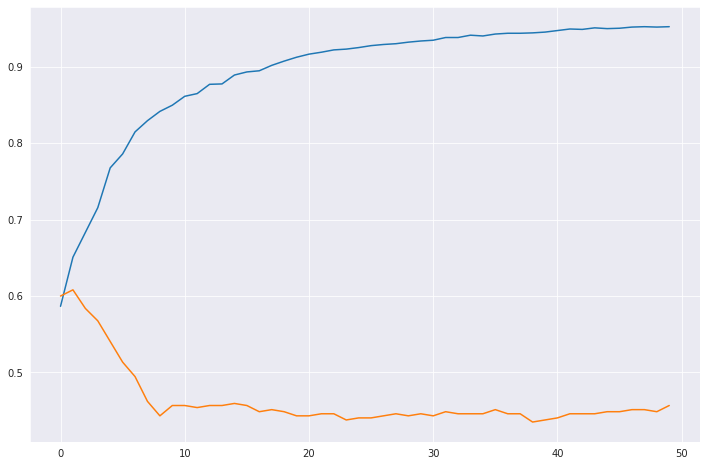

Максимальная точность на обучающей выборке: 0.952
Максимальная точность на проверочной выборке: 0.608


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_tBOW,
    test_data=worker.x_testBOW)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.957
Максимальная точность на проверочной выборке: 0.557




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.955
Максимальная точность на проверочной выборке: 0.508




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.958
Максимальная точность на проверочной выборке: 0.581




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.955
Максимальная точность на проверочной выборке: 0.595




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.955
Максимальная точность на проверочной выборке: 0.505




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.956
Максимальная точность на обучающей выборке: 0.958
Средняя точность на проверочной выборке: 0.549
Максимальная точность на проверочной выборке: 0.595


### **Эксп. №2 (Усиливаем Dense-слой до 64 нейронов) (59.2%)**

In [ ]:
def create_model():
  # Последовательная модель
  model = Sequential()
  # Входной полносвязный слой
  model.add(Dense(64, input_dim=max_words_count, activation="relu"))
  # Второй полносвязный слой
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(1e-4), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_tBOW,
                           worker.y_train,
                           validation_data=(worker.x_testBOW, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 2s 8ms/step - loss: 0.6831 - accuracy: 0.5729 - val_loss: 0.6756 - val_accuracy: 0.5973
Epoch 2/50
80/80 [==============================] - 0s 6ms/step - loss: 0.6483 - accuracy: 0.6680 - val_loss: 0.6712 - val_accuracy: 0.5973
Epoch 3/50
80/80 [==============================] - 1s 6ms/step - loss: 0.6173 - accuracy: 0.7181 - val_loss: 0.6750 - val_accuracy: 0.5622
Epoch 4/50
80/80 [==============================] - 0s 6ms/step - loss: 0.5848 - accuracy: 0.7556 - val_loss: 0.6829 - val_accuracy: 0.5432
Epoch 5/50
80/80 [==============================] - 0s 6ms/step - loss: 0.5518 - accuracy: 0.7920 - val_loss: 0.6893 - val_accuracy: 0.5351
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5184 - accuracy: 0.8244 - val_loss: 0.7081 - val_accuracy: 0.5081
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.4857 - accuracy: 0.8386 - val_loss: 0.7331 - val_accuracy: 0.4757
Epoch 8/50
80/80 [==

График обучения:


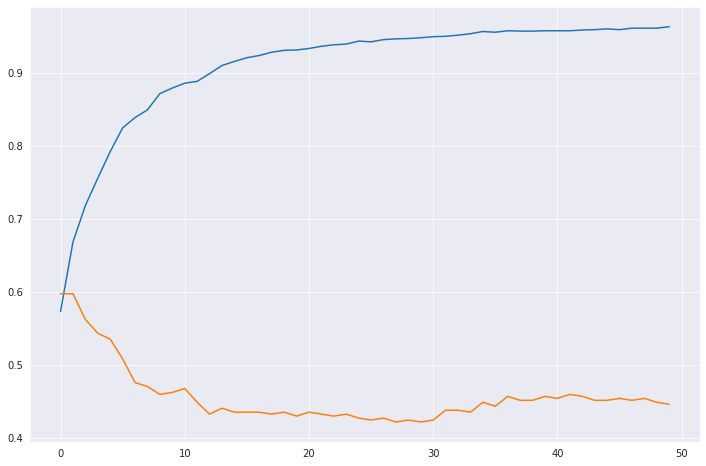

Максимальная точность на обучающей выборке: 0.963
Максимальная точность на проверочной выборке: 0.597


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_tBOW,
    test_data=worker.x_testBOW)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.964
Максимальная точность на проверочной выборке: 0.584




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.962
Максимальная точность на проверочной выборке: 0.592




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.963
Максимальная точность на проверочной выборке: 0.581




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.963
Максимальная точность на проверочной выборке: 0.549




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.963
Максимальная точность на проверочной выборке: 0.527




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.963
Максимальная точность на обучающей выборке: 0.964
Средняя точность на проверочной выборке: 0.566
Максимальная точность на проверочной выборке: 0.592


### **Эксп. №3 (Усиливаем Dense-слой до 256 нейронов) (62.7%)**

In [ ]:
def create_model():
  # Последовательная модель
  model = Sequential()
  # Входной полносвязный слой
  model.add(Dense(256, input_dim=max_words_count, activation="relu"))
  # Второй полносвязный слой
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(1e-4), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_tBOW,
                           worker.y_train,
                           validation_data=(worker.x_testBOW, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 1s 6ms/step - loss: 0.6695 - accuracy: 0.5810 - val_loss: 0.6930 - val_accuracy: 0.4865
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.7247 - val_loss: 0.7053 - val_accuracy: 0.4703
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5527 - accuracy: 0.8026 - val_loss: 0.7179 - val_accuracy: 0.4486
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5017 - accuracy: 0.8441 - val_loss: 0.7364 - val_accuracy: 0.4459
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 0.4530 - accuracy: 0.8654 - val_loss: 0.7750 - val_accuracy: 0.4405
Epoch 6/50
80/80 [==============================] - 0s 6ms/step - loss: 0.4095 - accuracy: 0.8796 - val_loss: 0.8102 - val_accuracy: 0.4486
Epoch 7/50
80/80 [==============================] - 0s 6ms/step - loss: 0.3699 - accuracy: 0.8942 - val_loss: 0.8282 - val_accuracy: 0.4514
Epoch 8/50
80/80 [==

График обучения:


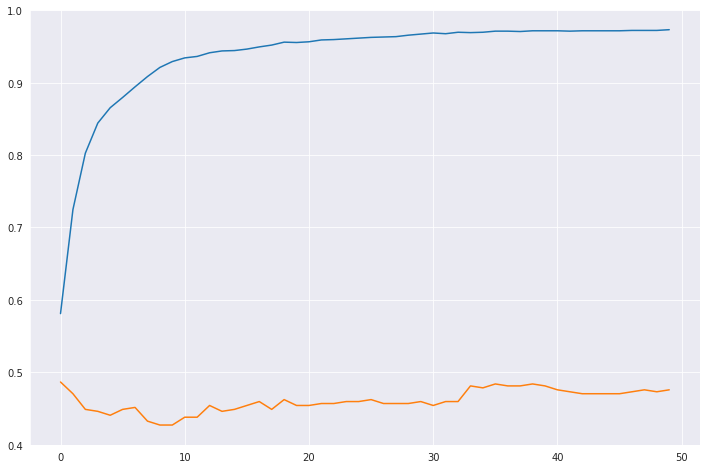

Максимальная точность на обучающей выборке: 0.973
Максимальная точность на проверочной выборке: 0.486


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_tBOW,
    test_data=worker.x_testBOW)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.974
Максимальная точность на проверочной выборке: 0.57




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.973
Максимальная точность на проверочной выборке: 0.614




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.973
Максимальная точность на проверочной выборке: 0.6




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.973
Максимальная точность на проверочной выборке: 0.559




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.974
Максимальная точность на проверочной выборке: 0.627




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.973
Максимальная точность на обучающей выборке: 0.974
Средняя точность на проверочной выборке: 0.594
Максимальная точность на проверочной выборке: 0.627


### **Эксп. №4 (Добавляем слой BatchNormalization) (56.8%)** *(не сработало)*

In [ ]:
def create_model():
  # Последовательная модель
  model = Sequential()
  # Входной полносвязный слой
  model.add(Dense(64, input_dim=max_words_count, activation="relu"))
  model.add(BatchNormalization())
  # Второй полносвязный слой
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(1e-4), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_tBOW,
                           worker.y_train,
                           validation_data=(worker.x_testBOW, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 2s 7ms/step - loss: 0.7301 - accuracy: 0.5622 - val_loss: 0.6929 - val_accuracy: 0.4919
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 0.5367 - accuracy: 0.7186 - val_loss: 0.6959 - val_accuracy: 0.5270
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 0.4299 - accuracy: 0.8102 - val_loss: 0.7128 - val_accuracy: 0.5108
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 0.3624 - accuracy: 0.8634 - val_loss: 0.7549 - val_accuracy: 0.4865
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 0.3136 - accuracy: 0.9003 - val_loss: 0.8119 - val_accuracy: 0.4568
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 0.2769 - accuracy: 0.9119 - val_loss: 0.8993 - val_accuracy: 0.4757
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 0.2405 - accuracy: 0.9383 - val_loss: 0.9696 - val_accuracy: 0.4622
Epoch 8/50
80/80 [==

График обучения:


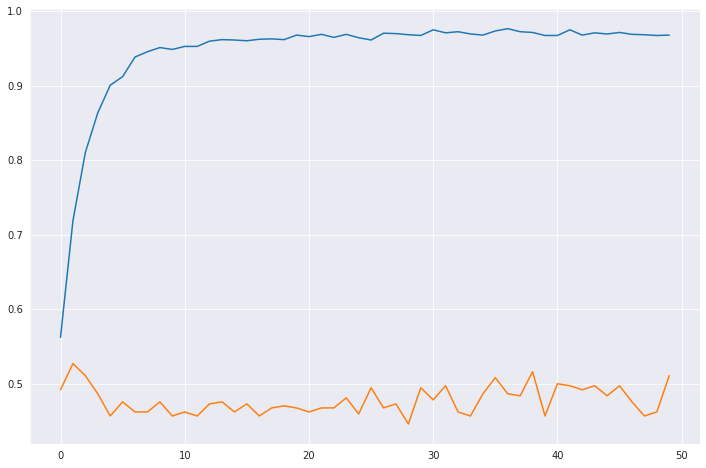

Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.527


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_tBOW,
    test_data=worker.x_testBOW)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.522




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.975
Максимальная точность на проверочной выборке: 0.551




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.565




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.522




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.568




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.977
Максимальная точность на обучающей выборке: 0.978
Средняя точность на проверочной выборке: 0.545
Максимальная точность на проверочной выборке: 0.568


### **Эксп. №5 (Добавляем еще один Dense-слой) (64.9%)**

In [ ]:
def create_model():
  # Последовательная модель
  model = Sequential()
  # Входной полносвязный слой
  model.add(Dense(64, input_dim=max_words_count, activation="relu"))
  model.add(Dense(128, activation='relu'))
  # Второй полносвязный слой
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(1e-4), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_tBOW,
                           worker.y_train,
                           validation_data=(worker.x_testBOW, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 2s 6ms/step - loss: 0.6873 - accuracy: 0.5850 - val_loss: 0.6719 - val_accuracy: 0.6486
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 0.6628 - accuracy: 0.6012 - val_loss: 0.6602 - val_accuracy: 0.6514
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6123 - val_loss: 0.6592 - val_accuracy: 0.6432
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5801 - accuracy: 0.7348 - val_loss: 0.6695 - val_accuracy: 0.5973
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 0.5062 - accuracy: 0.8097 - val_loss: 0.7080 - val_accuracy: 0.5189
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.4226 - accuracy: 0.8634 - val_loss: 0.7673 - val_accuracy: 0.4892
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 0.3470 - accuracy: 0.8957 - val_loss: 0.8429 - val_accuracy: 0.4757
Epoch 8/50
80/80 [==

График обучения:


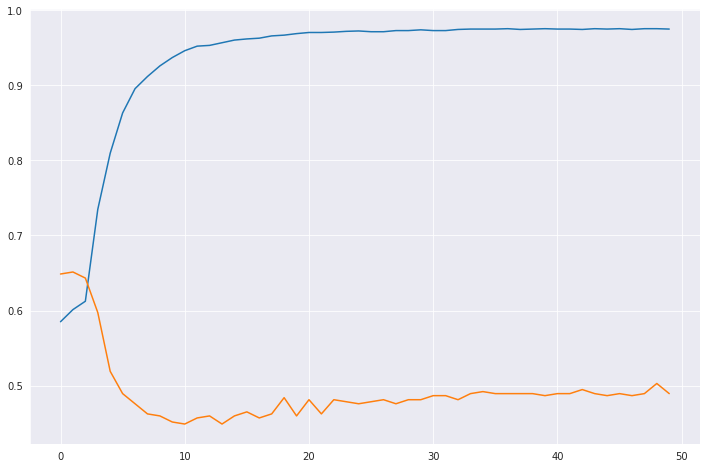

Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.651


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_tBOW,
    test_data=worker.x_testBOW)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.649




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.614




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.646




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.649




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.641




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.976
Максимальная точность на обучающей выборке: 0.976
Средняя точность на проверочной выборке: 0.639
Максимальная точность на проверочной выборке: 0.649


### **Эксп. №6 (Эмбеддинг) (65.7%)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Embedding(max_words_count, 32, input_length=padding_length))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(2e-3), loss='binary_crossentropy', metrics=['accuracy'])

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_trainE,
                           worker.y_train,
                           validation_data=(worker.x_testE, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 12s 135ms/step - loss: 0.6698 - accuracy: 0.5886 - val_loss: 0.6776 - val_accuracy: 0.6324
Epoch 2/50
80/80 [==============================] - 6s 75ms/step - loss: 0.5248 - accuracy: 0.7859 - val_loss: 0.6735 - val_accuracy: 0.6135
Epoch 3/50
80/80 [==============================] - 4s 44ms/step - loss: 0.3198 - accuracy: 0.9124 - val_loss: 0.6808 - val_accuracy: 0.5784
Epoch 4/50
80/80 [==============================] - 3s 35ms/step - loss: 0.1860 - accuracy: 0.9550 - val_loss: 0.7054 - val_accuracy: 0.6162
Epoch 5/50
80/80 [==============================] - 3s 32ms/step - loss: 0.1272 - accuracy: 0.9661 - val_loss: 0.7256 - val_accuracy: 0.6081
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 0.0987 - accuracy: 0.9671 - val_loss: 0.7894 - val_accuracy: 0.6081
Epoch 7/50
80/80 [==============================] - 2s 23ms/step - loss: 0.0816 - accuracy: 0.9717 - val_loss: 0.7956 - val_accuracy: 0.5973
Epoch 8/50


График обучения:


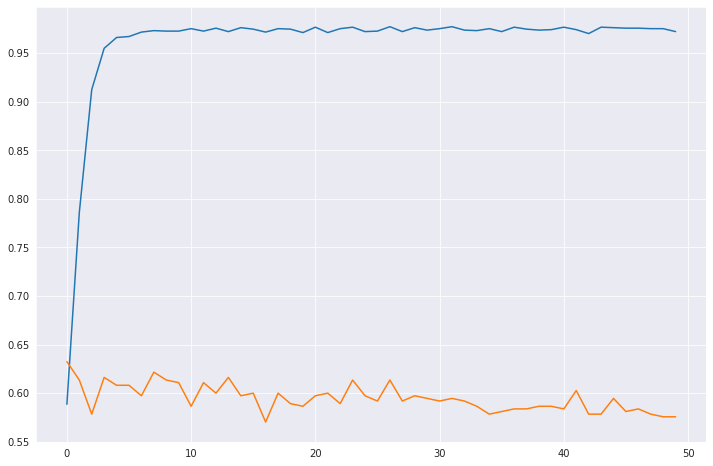

Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.632


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_trainE,
    test_data=worker.x_testE)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.657




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.979
Максимальная точность на проверочной выборке: 0.654




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.654




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.979
Максимальная точность на проверочной выборке: 0.651




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.649




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.978
Максимальная точность на обучающей выборке: 0.979
Средняя точность на проверочной выборке: 0.653
Максимальная точность на проверочной выборке: 0.657


### **Эксп. №7 (Усиливаем Эмбеддинг) (66.5%)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Embedding(max_words_count, 128, input_length=padding_length))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(2e-3), loss='binary_crossentropy', metrics=['accuracy'])

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_trainE,
                           worker.y_train,
                           validation_data=(worker.x_testE, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 10s 117ms/step - loss: 0.6394 - accuracy: 0.6326 - val_loss: 0.6675 - val_accuracy: 0.6378
Epoch 2/50
80/80 [==============================] - 6s 74ms/step - loss: 0.3003 - accuracy: 0.9150 - val_loss: 0.7070 - val_accuracy: 0.5946
Epoch 3/50
80/80 [==============================] - 3s 41ms/step - loss: 0.1194 - accuracy: 0.9641 - val_loss: 0.7530 - val_accuracy: 0.6432
Epoch 4/50
80/80 [==============================] - 3s 37ms/step - loss: 0.0816 - accuracy: 0.9701 - val_loss: 0.8098 - val_accuracy: 0.5946
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 0.0664 - accuracy: 0.9727 - val_loss: 0.8434 - val_accuracy: 0.5973
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 0.0592 - accuracy: 0.9696 - val_loss: 0.8723 - val_accuracy: 0.6027
Epoch 7/50
80/80 [==============================] - 2s 22ms/step - loss: 0.0552 - accuracy: 0.9671 - val_loss: 0.9038 - val_accuracy: 0.5919
Epoch 8/50


График обучения:


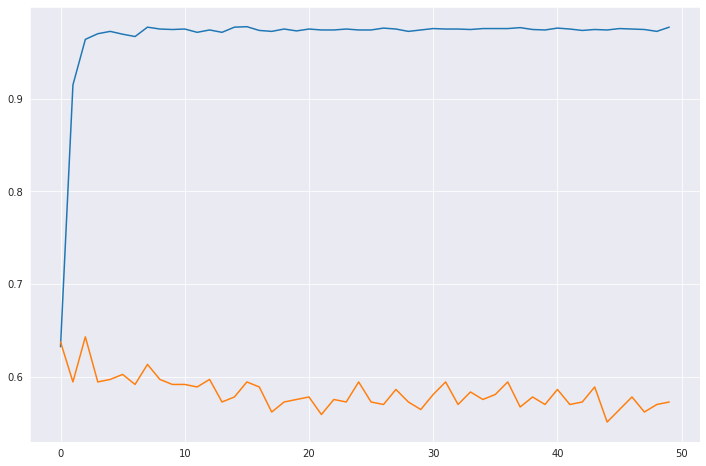

Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.643


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_trainE,
    test_data=worker.x_testE)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.665




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.627




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.643




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.632




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.635




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.977
Максимальная точность на обучающей выборке: 0.978
Средняя точность на проверочной выборке: 0.641
Максимальная точность на проверочной выборке: 0.665


### **Эксп. №8 (Усиливаем Эмбеддинг) (70%)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Embedding(max_words_count, 256, input_length=padding_length))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(2e-3), loss='binary_crossentropy', metrics=['accuracy'])

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_trainE,
                           worker.y_train,
                           validation_data=(worker.x_testE, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 12s 136ms/step - loss: 0.6473 - accuracy: 0.6245 - val_loss: 0.6632 - val_accuracy: 0.6486
Epoch 2/50
80/80 [==============================] - 9s 111ms/step - loss: 0.3746 - accuracy: 0.8750 - val_loss: 0.6934 - val_accuracy: 0.5973
Epoch 3/50
80/80 [==============================] - 4s 46ms/step - loss: 0.1603 - accuracy: 0.9585 - val_loss: 0.7110 - val_accuracy: 0.6486
Epoch 4/50
80/80 [==============================] - 2s 26ms/step - loss: 0.0970 - accuracy: 0.9696 - val_loss: 0.7762 - val_accuracy: 0.6324
Epoch 5/50
80/80 [==============================] - 2s 18ms/step - loss: 0.0713 - accuracy: 0.9691 - val_loss: 0.8219 - val_accuracy: 0.6568
Epoch 6/50
80/80 [==============================] - 2s 29ms/step - loss: 0.0674 - accuracy: 0.9701 - val_loss: 0.8443 - val_accuracy: 0.6189
Epoch 7/50
80/80 [==============================] - 2s 23ms/step - loss: 0.0575 - accuracy: 0.9747 - val_loss: 0.8858 - val_accuracy: 0.6270
Epoch 8/50

График обучения:


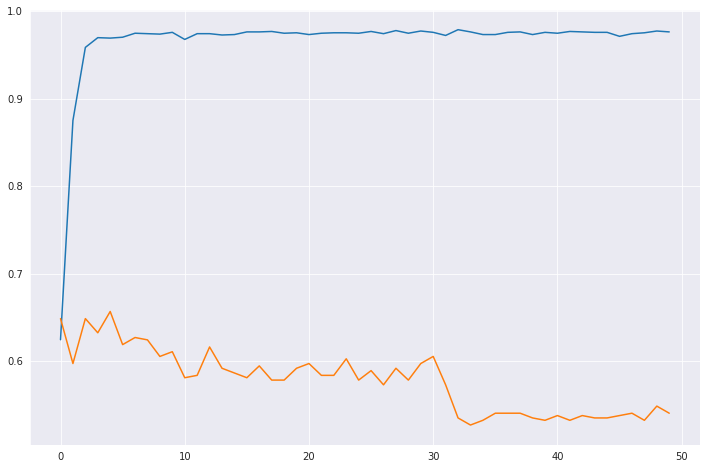

Максимальная точность на обучающей выборке: 0.979
Максимальная точность на проверочной выборке: 0.657


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_trainE,
    test_data=worker.x_testE)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.654




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.681




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.977
Максимальная точность на проверочной выборке: 0.638




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.7




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.978
Максимальная точность на проверочной выборке: 0.681




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.977
Максимальная точность на обучающей выборке: 0.978
Средняя точность на проверочной выборке: 0.671
Максимальная точность на проверочной выборке: 0.7


### **Эксп. №9 (Embedding: меняем Flatten на GlobalMaxPooling) (64.3%)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Embedding(max_words_count, 128, input_length=padding_length))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(2e-3), loss='binary_crossentropy', metrics=['accuracy'])

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_trainE,
                           worker.y_train,
                           validation_data=(worker.x_testE, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=50, 
                           verbose=1)

Epoch 1/50
80/80 [==============================] - 8s 93ms/step - loss: 0.6664 - accuracy: 0.5825 - val_loss: 0.6509 - val_accuracy: 0.6351
Epoch 2/50
80/80 [==============================] - 4s 49ms/step - loss: 0.5745 - accuracy: 0.7196 - val_loss: 0.6714 - val_accuracy: 0.6000
Epoch 3/50
80/80 [==============================] - 3s 39ms/step - loss: 0.4191 - accuracy: 0.8750 - val_loss: 0.6939 - val_accuracy: 0.5892
Epoch 4/50
80/80 [==============================] - 3s 32ms/step - loss: 0.2886 - accuracy: 0.9089 - val_loss: 0.7209 - val_accuracy: 0.5784
Epoch 5/50
80/80 [==============================] - 1s 11ms/step - loss: 0.2037 - accuracy: 0.9388 - val_loss: 0.7693 - val_accuracy: 0.5703
Epoch 6/50
80/80 [==============================] - 1s 18ms/step - loss: 0.1498 - accuracy: 0.9560 - val_loss: 0.7936 - val_accuracy: 0.5784
Epoch 7/50
80/80 [==============================] - 1s 15ms/step - loss: 0.1143 - accuracy: 0.9671 - val_loss: 0.8336 - val_accuracy: 0.5757
Epoch 8/50
80

График обучения:


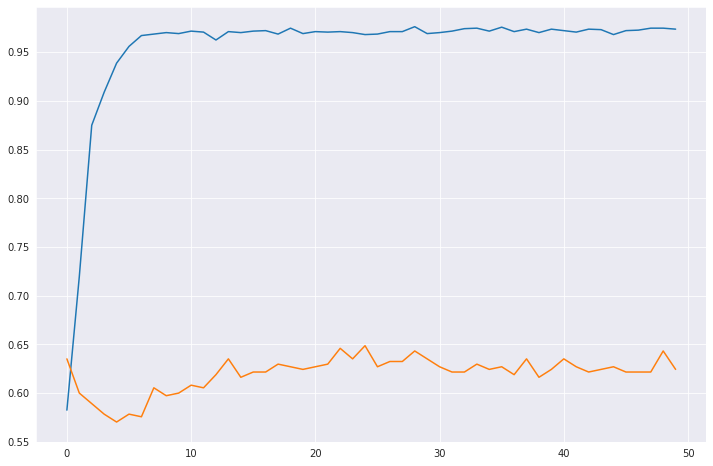

Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.649


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5,
    train_data=worker.x_trainE,
    test_data=worker.x_testE)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.975
Максимальная точность на проверочной выборке: 0.635




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.975
Максимальная точность на проверочной выборке: 0.635




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.975
Максимальная точность на проверочной выборке: 0.635




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.643




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.635




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.975
Максимальная точность на обучающей выборке: 0.976
Средняя точность на проверочной выборке: 0.637
Максимальная точность на проверочной выборке: 0.643
